In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import import_ipynb
import networks
import DataLoader_PIE
import utils
import time
import numpy as np
from sklearn.metrics import recall_score, accuracy_score

importing Jupyter notebook from networks.ipynb
importing Jupyter notebook from DataLoader_PIE.ipynb
importing Jupyter notebook from utils.ipynb


In [2]:
class args():
    def __init__(self):
        self.base_out_features = 2048
        self.t_obs = 8
        self.batch_size = 20
        self.scene_shape = [3, 144, 256]
        self.base_shape = [2048, 9, 16]
        self.hidden_size = 128
        self.embedding_size = 64
        self.input_size = 2
        self.output_size = 2
        self.sample = True
        self.n_train_sequences = 12000
        self.n_val_sequences = 3000
        self.trainOrVal = 'train'
        
        #dataset
        self.jaad_dataset = '../../../../data/smailait-data/jaad/annotations'
        self.dtype = 'train'
        self.from_file = True
        self.file = '/data/smailait-data/train_crossing.csv'
        self.seq_len = 18
        self.predicted_seq_len = 18
        self.crop = 0.3
        self.activity_h = 9
        self.activity_w = 16
        self.truncate = 0
        self.final_frame_offset = 0
        self.loader_workers = 8
        self.loader_shuffle = True
        self.pin_memory = False
        self.image_resize = [240, 426]
        self.image_size = [1080, 1920]
        self.device='cuda'
        
args = args()

In [3]:
class PS_PIE(nn.Module):
    def __init__(self, args):
        super(PS_PIE, self).__init__()
        
        self.speed_encoder = nn.LSTM(input_size=4, hidden_size=256)
        self.pos_encoder   = nn.LSTM(input_size=4, hidden_size=256)
        
        self.pos_embedding = nn.Sequential(nn.Linear(in_features=2, out_features=4),
                                           nn.ReLU())
        
        self.speed_decoder    = nn.LSTMCell(input_size=4, hidden_size=256)
        self.crossing_decoder = nn.LSTMCell(input_size=4, hidden_size=256)
        
        self.fc_speed    = nn.Linear(in_features=256, out_features=4)
        self.fc_crossing = nn.Sequential(nn.Linear(in_features=256, out_features=2),
                                         nn.ReLU())
        
        self.hardtan = nn.Hardtanh(min_val=-100, max_val=100)
        self.softmax = nn.Softmax(dim=1)
        
        self.args = args
        
    def forward(self, mode, speed=None, pos=None):

        _, (hsp, csp) = self.speed_encoder(speed.permute(1,0,2))
        hsp = hsp.squeeze(0)
        csp = csp.squeeze(0)
        
        _, (hpo, cpo) = self.pos_encoder(pos.permute(1,0,2))
        hpo = hpo.squeeze(0)
        cpo = cpo.squeeze(0)
        
        if mode == 'speed':
            speed_outputs    = torch.tensor([], device='cuda')
            in_sp = speed[:,-1,:]
            #hds = torch.cat((hsp, hpo), dim=1)
            #cds = torch.cat((csp, cpo), dim=1)
            hds = hpo + hsp
            cds = cpo + csp
            for i in range(8):
                hds, cds         = self.speed_decoder(in_sp, (hds, cds))
                speed_output     = self.hardtan(self.fc_speed(hds))
                speed_outputs    = torch.cat((speed_outputs, speed_output.unsqueeze(1)), dim = 1)
                in_sp            = speed_output.detach()
                
            return speed_outputs


        elif mode == 'cross':
            crossing_outputs = torch.tensor([], device='cuda')
            in_cr = pos[:,-1,:]
            #hdc = torch.cat((hpo, hsp), dim=1)
            #cdc = torch.cat((cpo, csp), dim=1)
            hdc = hpo + hsp
            cdc = cpo + csp
            for i in range(8):
                hdc, cdc         = self.crossing_decoder(in_cr, (hdc, cdc))
                crossing_output  = self.fc_crossing(hdc)
                in_cr            = self.pos_embedding(crossing_output).detach()
                crossing_output  = self.softmax(crossing_output)
                crossing_outputs = torch.cat((crossing_outputs, crossing_output.unsqueeze(1)), dim = 1)

            return crossing_outputs

In [4]:
net = PS_PIE(args).to('cuda')

In [5]:
train, val, test = DataLoader_PIE.data_loader(args)

frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
future_crossing
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
future_crossing
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
future_crossing
val  loaded


In [6]:
learning_rate  = 0.00001
optimizer     = optim.Adam(net.parameters(), lr=learning_rate)
scheduler      = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold = 1e-8, verbose=True)
mse            = nn.MSELoss()
bce            = nn.BCELoss()
train_s_scores = []
train_c_scores = []
val_s_scores   = []
val_c_scores   = []
log            = open('log_P_PIE.txt', 'w+')

In [7]:
for epoch in range(1, 101):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_c_loss = 0
    avg_epoch_val_c_loss   = 0
    
    ade  = 0
    fde  = 0
    aiou = 0
    fiou = 0
    avg_acc = 0
    avg_rec = 0
    
    counter = 0
    for idx, (obs_s, target_s, obs_p, target_p, target_c) in enumerate(train):
        counter += 1
        obs_s    = obs_s.type(torch.float32).to(device='cuda')
        target_s = target_s.type(torch.float32).to(device='cuda')
        obs_p    = obs_p.type(torch.float32).to(device='cuda')
        target_p = target_p.type(torch.float32).to(device='cuda')
        target_c = target_c.type(torch.float32).to(device='cuda')
        
        net.zero_grad()
        speed_preds = net(mode='speed', speed=obs_s, pos=obs_p)
        speed_loss  = mse(speed_preds, target_s)/100
        
        crossing_preds = net(mode='cross', speed=obs_s, pos=obs_p)
        crossing_loss = 0
        for i in range(8):
            crossing_loss += bce(crossing_preds[:,i,:], target_c[:,i,:])
        crossing_loss /= 8
        loss = speed_loss + crossing_loss
        loss.backward()
        optimizer.step()
        
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_c_loss += float(crossing_loss)
        
    avg_epoch_train_s_loss/=counter
    avg_epoch_train_c_loss/=counter
    train_s_scores.append(avg_epoch_train_s_loss)
    train_c_scores.append(avg_epoch_train_c_loss)
    
    counter=0
    for idx, (obs_s, target_s, obs_p, target_p, target_c) in enumerate(test):
        counter+=1
        obs_s    = obs_s.type(torch.float32).to(device='cuda')
        target_s = target_s.type(torch.float32).to(device='cuda')
        obs_p    = obs_p.type(torch.float32).to(device='cuda')
        target_p = target_p.type(torch.float32).to(device='cuda')
        target_c = target_c.type(torch.float32).to(device='cuda')
        
        with torch.no_grad():
            speed_preds = net(mode='speed', speed=obs_s, pos=obs_p)
            crossing_preds = net(mode='cross', speed=obs_s, pos=obs_p)
            speed_loss    = mse(speed_preds, target_s)/100
            crossing_loss = 0
            for i in range(8):
                crossing_loss += bce(crossing_preds[:,i,:], target_c[:,i,:])
            crossing_loss /= 8
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_c_loss += float(crossing_loss)
            preds_p = utils.speed2pos(speed_preds, obs_p, 20, 'cuda')
            ade += float(utils.ADE_c(preds_p, target_p[:,:-1,:]))
            fde += float(utils.FDE_c(preds_p, target_p[:,:-1,:]))
            aiou += float(utils.AIOU(preds_p, target_p[:,:-1,:]))
            fiou += float(utils.FIOU(preds_p, target_p[:,:-1,:]))
            #avg_acc += float(torch.sum(nn.Threshold(0.,0.)(nn.Threshold(-0.5, 1.)(-1*crossing_preds[:,:,0]))==target_c[:,:-1,0]).type(torch.float32)/(20*8))
            avg_rec += recall_score(nn.Threshold(0.,0.)(nn.Threshold(-0.5, 1.)(-1*crossing_preds[:,:,0])).reshape(-1).detach().cpu().numpy(), target_c[:,:-1,0].reshape(-1).cpu().numpy(), average='binary', zero_division=1)
            avg_acc += accuracy_score(nn.Threshold(0.,0.)(nn.Threshold(-0.5, 1.)(-1*crossing_preds[:,:,0])).reshape(-1).detach().cpu().numpy(), target_c[:,:-1,0].reshape(-1).cpu().numpy())
        
        avg_epoch_val_s_loss += float(speed_loss)
        avg_epoch_val_c_loss += float(crossing_loss)
        
    avg_epoch_val_s_loss/=counter
    avg_epoch_val_c_loss/=counter
    val_s_scores.append(avg_epoch_val_s_loss)
    val_c_scores.append(avg_epoch_val_c_loss)
    ade  /= counter
    fde  /= counter     
    aiou /= counter
    fiou /= counter
    avg_acc/=counter
    avg_rec/=counter
    
    scheduler.step(speed_loss)
    
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tc: %.4f'% avg_epoch_train_c_loss, 
          '| vs: %.4f'% avg_epoch_val_s_loss, '| vc: %.4f'% avg_epoch_val_c_loss, '| ade: %.4f'% ade, 
          '| fde: %.4f'% fde, '| aiou: %.4f'% aiou, '| fiou: %.4f'% fiou, '| acc: %.4f'% avg_acc, '| rec: %.4f'% avg_rec, 
          '| t:%.4f'%(time.time()-start))
    
    log.write("E: "+str(epoch)+" | ts_l: "+str(avg_epoch_train_s_loss)+" | tc_l: "+str(avg_epoch_train_c_loss)+ \
              " | vs_l: "+str(avg_epoch_val_s_loss)+" | vc_l: "+str(avg_epoch_val_c_loss)+"| ade: "+str(ade)+ \
              "| fde: "+str(fde)+"| aiou: "+str(aiou)+"| fiou: "+str(fiou)+"\n")

e: 1 | ts: 0.4264 | tc: 0.5665 | vs: 0.9448 | vc: 0.9842 | ade: 30.2358 | fde: 54.5946 | aiou: 0.4942 | fiou: 0.3023 | acc: 0.7672 | rec: 0.8351 | t:18.4651
e: 2 | ts: 0.3529 | tc: 0.3894 | vs: 0.7610 | vc: 0.8084 | ade: 23.0982 | fde: 41.0727 | aiou: 0.5818 | fiou: 0.4015 | acc: 0.8301 | rec: 0.7503 | t:19.1182
e: 3 | ts: 0.3028 | tc: 0.3368 | vs: 0.7002 | vc: 0.7602 | ade: 20.3152 | fde: 36.3433 | aiou: 0.6179 | fiou: 0.4372 | acc: 0.8432 | rec: 0.7073 | t:18.2957
e: 4 | ts: 0.2764 | tc: 0.3159 | vs: 0.6490 | vc: 0.7508 | ade: 18.1099 | fde: 31.8817 | aiou: 0.6522 | fiou: 0.5006 | acc: 0.8430 | rec: 0.7169 | t:18.8589
e: 5 | ts: 0.2569 | tc: 0.3012 | vs: 0.6188 | vc: 0.7291 | ade: 16.6623 | fde: 29.1251 | aiou: 0.6714 | fiou: 0.5310 | acc: 0.8460 | rec: 0.7246 | t:18.4999
e: 6 | ts: 0.2423 | tc: 0.2886 | vs: 0.5890 | vc: 0.7144 | ade: 15.5305 | fde: 27.0199 | aiou: 0.6836 | fiou: 0.5465 | acc: 0.8511 | rec: 0.7191 | t:18.9139
e: 7 | ts: 0.2308 | tc: 0.2777 | vs: 0.5694 | vc: 0.7063 |

e: 53 | ts: 0.1541 | tc: 0.1934 | vs: 0.4233 | vc: 0.6149 | ade: 9.9973 | fde: 16.6031 | aiou: 0.7378 | fiou: 0.6111 | acc: 0.8813 | rec: 0.7526 | t:19.9735
e: 54 | ts: 0.1542 | tc: 0.1934 | vs: 0.4227 | vc: 0.6178 | ade: 9.9873 | fde: 16.5975 | aiou: 0.7383 | fiou: 0.6117 | acc: 0.8806 | rec: 0.7747 | t:18.5456
e: 55 | ts: 0.1542 | tc: 0.1934 | vs: 0.4179 | vc: 0.6175 | ade: 9.9659 | fde: 16.5299 | aiou: 0.7379 | fiou: 0.6113 | acc: 0.8807 | rec: 0.7677 | t:19.3496
e: 56 | ts: 0.1541 | tc: 0.1933 | vs: 0.4235 | vc: 0.6140 | ade: 9.9850 | fde: 16.6095 | aiou: 0.7379 | fiou: 0.6109 | acc: 0.8811 | rec: 0.7697 | t:18.6791
Epoch    56: reducing learning rate of group 0 to 1.0000e-08.
e: 57 | ts: 0.1541 | tc: 0.1934 | vs: 0.4234 | vc: 0.6115 | ade: 10.0109 | fde: 16.6306 | aiou: 0.7375 | fiou: 0.6107 | acc: 0.8811 | rec: 0.7584 | t:19.1130
e: 58 | ts: 0.1541 | tc: 0.1933 | vs: 0.4242 | vc: 0.6182 | ade: 10.0046 | fde: 16.6146 | aiou: 0.7375 | fiou: 0.6108 | acc: 0.8808 | rec: 0.7508 | t:19

In [8]:
avg_epoch_val_loss = 0
ade = 0
fde = 0
aiou = 0
fiou = 0
avg_rec = 0
avg_acc = 0
counter=0
for idx, (obs_s, target_s, obs_p, target_p, target_c) in enumerate(test):
    counter+=1
    obs_s    = obs_s.type(torch.float32).to(device='cuda')
    target_s = target_s.type(torch.float32).to(device='cuda')
    obs_p    = obs_p.type(torch.float32).to(device='cuda')
    target_p = target_p.type(torch.float32).to(device='cuda')
    target_c = target_c.type(torch.float32).to(device='cuda')

    with torch.no_grad():
        speed_preds = net(mode='speed', speed=obs_s, pos=obs_p)
        crossing_preds = net(mode='cross', speed=obs_s, pos=obs_p)
        speed_loss    = mse(speed_preds, target_s)/10
        crossing_loss = 0
        for i in range(8):
            crossing_loss += bce(crossing_preds[:,i,:], target_c[:,i,:])
        crossing_loss /= 8
        avg_epoch_val_s_loss += float(speed_loss)
        avg_epoch_val_c_loss += float(crossing_loss)
        preds_p = utils.speed2pos(speed_preds, obs_p, 20, 'cuda')
        ade += float(utils.ADE_c(preds_p, target_p[:,:-1,:]))
        fde += float(utils.FDE_c(preds_p, target_p[:,:-1,:]))
        aiou += float(utils.AIOU(preds_p, target_p[:,:-1,:]))
        fiou += float(utils.FIOU(preds_p, target_p[:,:-1,:]))
        avg_rec += recall_score(nn.Threshold(0.,0.)(nn.Threshold(-0.5, 1.)(-1*crossing_preds[:,:,0])).reshape(-1).detach().cpu().numpy(), target_c[:,:-1,0].reshape(-1).cpu().numpy(), average='binary', zero_division=1)
        avg_acc += accuracy_score(nn.Threshold(0.,0.)(nn.Threshold(-0.5, 1.)(-1*crossing_preds[:,:,0])).reshape(-1).detach().cpu().numpy(), target_c[:,:-1,0].reshape(-1).cpu().numpy())
        

    avg_epoch_val_s_loss += float(speed_loss)
    avg_epoch_val_c_loss += float(crossing_loss)

avg_epoch_val_s_loss/=counter
avg_epoch_val_c_loss/=counter
ade  /= counter
fde  /= counter     
aiou /= counter
fiou /= counter
avg_acc/=counter
avg_rec/=counter

print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tc: %.4f'% avg_epoch_train_c_loss, 
      '| vs: %.4f'% avg_epoch_val_s_loss, '| vc: %.4f'% avg_epoch_val_c_loss, '| ade: %.4f'% ade, 
      '| fde: %.4f'% fde, '| aiou: %.4f'% aiou, '| fiou: %.4f'% fiou, '| acc: %.4f'% avg_acc, '| rec: %.4f'% avg_rec, 
          '| t:%.4f'%(time.time()-start))

e: 100 | ts: 0.1541 | tc: 0.1933 | vs: 4.2282 | vc: 0.6215 | ade: 9.9863 | fde: 16.5967 | aiou: 0.7379 | fiou: 0.6112 | acc: 0.8812 | rec: 0.7518 | t:21.6720


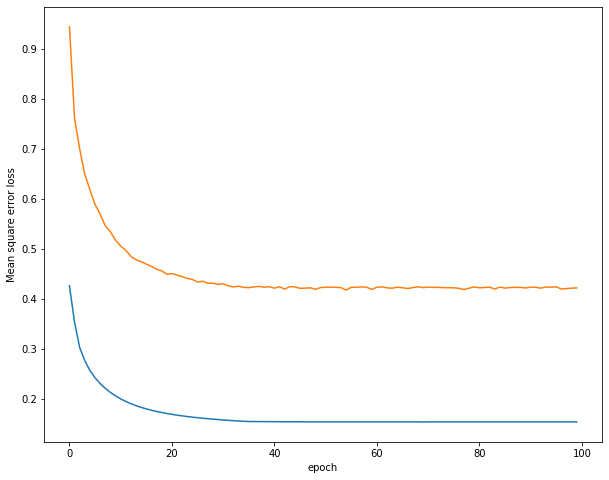

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(list(range(len(train_s_scores))), train_s_scores, label = 'Training loss')
plt.plot(list(range(len(val_s_scores))), val_s_scores, label = 'Validation loss')
plt.xlabel('epoch')
plt.ylabel('Mean square error loss')
plt.show()